In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt

c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomFaceNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = InceptionResnetV1(pretrained='vggface2', classify=False)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.backbone(x)  # [B, 512]
        x = self.fc(x)        # [B, num_classes]
        return x

In [3]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None, has_faces_label=True):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.has_faces_label = has_faces_label
        
        individuals = os.listdir(root_dir)
        self.class_to_idx = {ind: i for i, ind in enumerate(individuals)}

        for ind in individuals:
            if self.has_faces_label:
                img_dir =f"{root_dir}/{ind}/images"
                label_dir = f"{root_dir}/{ind}/labels"
            else: 
                img_dir =f"{root_dir}/{ind}"
            if os.path.exists(img_dir):
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    image = Image.open(img_path).convert("RGB")
                    if self.has_faces_label: 
                        label_name = img_name.replace(".png", ".txt")
                        label_name = label_name.replace(".jpg", ".txt")
                        label_name = label_name.replace(".JPG", ".txt")
                        label_path = os.path.join(label_dir, label_name)
                        bbox = self.read_yolo_label(label_path, image.width, image.height)
                        image = image.crop(bbox)
                    self.data.append(image)
                    self.labels.append(self.class_to_idx[ind])
        
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def read_yolo_label(self, label_path, img_width, img_height):
        with open(label_path, "r") as f:
            lines = f.readlines()
        if not lines:
            return None  
        
        face_annotation = None
        for line in lines: 
            if line[0] == "0":
                face_annotation = line
        _, x_center, y_center, width, height = map(float, face_annotation.split())
        
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        
        return (x1, y1, x2, y2)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.data[idx]
        plt.imshow(image)
        plt.axis('off')  # Masque les axes
        plt.show()
        """plt.imshow(image)
        plt.axis("off")  # Enlever les axes pour une meilleure lisibilité
        plt.title(f"Label: {label}")  # Afficher le label de l'image
        plt.show()
        """
        if self.transform:
            image = self.transform(image)

        return image, label



In [4]:
def train_classifier(model, train_loader, val_loader, criterion, optimizer, device, save_model_file, num_epochs, patience):
    model.to(device)
    criterion.to(device)
    
    best_val_loss = float("inf")
    best_model_state = None 
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-----------------------")
        
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        accuracy = correct / total
        print(f"Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                logits = model(images)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(logits, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"Early stopping: {epochs_without_improvement}/{patience}")

            if epochs_without_improvement >= patience:
                break
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, save_model_file)

In [5]:
def create_model(dataset_path, model_file, transform, nb_layer_fine_tune, has_faces_label, learning_rate=0.001, nb_epoch=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(os.listdir(dataset_path + "/train"))
    
    facenet = CustomFaceNet(num_classes)
    facenet = facenet.to(device)

    # Geler tout le backbone
    for param in facenet.backbone.parameters():
        param.requires_grad = False

    # Débloquer les dernières couches du backbone pour fine-tune
    for layer in list(facenet.backbone.children())[-nb_layer_fine_tune:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Laisser la fc toujours entraînable
    for param in facenet.fc.parameters():
        param.requires_grad = True

    train_dataset = TripletDataset(f"{dataset_path}/train", transform=transform, has_faces_label=has_faces_label)
    val_dataset = TripletDataset(f"{dataset_path}/val", transform=transform, has_faces_label=has_faces_label)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, facenet.parameters()), lr=learning_rate)

    train_classifier(facenet, train_loader, val_loader, criterion, optimizer, device, model_file, num_epochs=nb_epoch, patience=patience)

<h1>Tuning of the following hyperparameter: number of layer to fine-tune<h1>

Training of the different models for ChimpRec:

In [ ]:
dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"

# Définition des transformations pour les images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

layers_to_test = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

for nb_layer in layers_to_test: 
    model_file = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_fc/facenet_{nb_layer}_layers_fc.pth"
    create_model(dataset_path, model_file, transform, nb_layer, True, nb_epoch=100)

Sequential(
  (0): Block17(
    (branch0): BasicConv2d(
      (conv): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (branch1): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): BasicConv2d(
        (conv): Conv2d(128, 128, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): BasicConv2d(
        (conv): Conv2d(128, 128, kernel_size=(7, 1), stride=(1, 1), padding=(3, 0), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
     

KeyboardInterrupt: 

Training of the different models for CCR:

In [ ]:
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"

# Définition des transformations pour les images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

layers_to_test = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

for nb_layer in layers_to_test: 
    model_file = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_fc/facenet_{nb_layer}_layers_fc.pth"
    create_model(dataset_path, model_file, transform, nb_layer, False, nb_epoch=100)

To predict new faces:

In [6]:
def predict_image_with_fc(image, model, transform, device):
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class, probabilities.cpu().numpy()

Test for prediction:

In [ ]:
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

num_classes = len(os.listdir(os.path.join(dataset_path, "train")))
model_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_fc/facenet_12_layers_fc.pth"
facenet = CustomFaceNet(num_classes=num_classes)
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()

train_dataset = TripletDataset(os.path.join(dataset_path, "train"), transform=transform, has_faces_label=False)
class_names = list(train_dataset.class_to_idx.keys())
print("Classes :", class_names)

image_path = os.path.join(dataset_path, "test", "FANLE_73.jpg")
predicted_label, _ = predict_image_with_fc(image_path, facenet, transform, device)

print("Label prédict :", predicted_label)
print("Identité prédite :", class_names[predicted_label])


Graph for ChimpRec:

In [40]:
dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

num_classes = len(os.listdir(f"{dataset_path}/train"))

test_dataset = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Test_set"
val_dataset = f"{dataset_path}/val"
precisions_per_model = {}
for layer in [5,6,7,8,9,10,11,12,13,14,15,16,17,18]: 
    model_path = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_fc/facenet_{layer}_layers_fc.pth"
    facenet = CustomFaceNet(num_classes=num_classes)
    facenet.load_state_dict(torch.load(model_path, map_location=device))
    facenet = facenet.to(device)
    facenet.eval()

    train_dataset = TripletDataset(os.path.join(dataset_path, "train"), transform=transform)
    class_names = list(train_dataset.class_to_idx.keys())

    correctly_classified = 0
    total_img = 0
    for indiv in os.listdir(val_dataset): 
        for img in os.listdir(f"{val_dataset}/{indiv}/images"):
            total_img += 1
            img_path = f"{val_dataset}/{indiv}/images/{img}" 
            label_name = img.replace(".png", ".txt")
            label_name = label_name.replace(".jpg", ".txt")
            label_name = label_name.replace(".JPG", ".txt")
            label_path = os.path.join(f"{val_dataset}/{indiv}/labels", label_name)
            image = Image.open(img_path).convert("RGB")
            bbox = train_dataset.read_yolo_label(label_path, image.width, image.height)
            image = image.crop(bbox)

            predicted_label, _ = predict_image_with_fc(image, facenet, transform, device)
        
            predicted_identity = class_names[predicted_label]

            if predicted_identity == indiv: 
                correctly_classified += 1
    precisions_per_model[layer] = (correctly_classified/total_img)

print(precisions_per_model)

{5: 0.7973568281938326, 6: 0.73568281938326, 7: 0.8237885462555066, 8: 0.8502202643171806, 9: 0.9162995594713657, 10: 0.762114537444934, 11: 0.7797356828193832, 12: 0.9427312775330396, 13: 0.9559471365638766, 14: 0.960352422907489, 15: 0.9427312775330396, 16: 0.73568281938326, 17: 0.920704845814978, 18: 0.8986784140969163}


Graph for CCR:

In [ ]:
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

num_classes = len(os.listdir(f"{dataset_path}/train"))

test_dataset = f"{dataset_path}/test"
val_dataset = f"{dataset_path}/val"

precisions_per_model = {}

for layer in [5,6,7,8,9,10,11,12,13,14,15,16,17,18]: 
    model_path = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_fc/facenet_{layer}_layers_fc.pth"
    facenet = CustomFaceNet(num_classes=num_classes)
    facenet.load_state_dict(torch.load(model_path, map_location=device))
    facenet = facenet.to(device)
    facenet.eval()

    train_dataset = TripletDataset(os.path.join(dataset_path, "train"), transform=transform)#, has_faces_label=False)
    class_names = list(train_dataset.class_to_idx.keys())

    correctly_classified = 0
    total_img = 0
    for indiv in os.listdir(val_dataset): 
        for img in os.listdir(f"{val_dataset}/{indiv}"):
            total_img += 1
            img_path = f"{val_dataset}/{indiv}/{img}" 
            image = Image.open(img_path).convert("RGB")

            predicted_label, _ = predict_image_with_fc(image, facenet, transform, device)
        
            predicted_identity = class_names[predicted_label]

            if predicted_identity == indiv: 
                correctly_classified += 1
    precisions_per_model[layer] = (correctly_classified/total_img)
print(precisions_per_model)

{5: 0.4712, 6: 0.5716, 7: 0.4712, 8: 0.416, 9: 0.7036, 10: 0.384, 11: 0.6932, 12: 0.6772, 13: 0.6916, 14: 0.6992, 15: 0.6676, 16: 0.5428, 17: 0.6744, 18: 0.6656}


Résultats du code au dessus pour ChimpRec et CCR:

In [2]:
precisions_ccr = {5: 0.4712, 6: 0.5716, 7: 0.4712, 8: 0.416, 9: 0.7036, 10: 0.384, 11: 0.6932, 12: 0.6772, 13: 0.6916, 14: 0.6992, 15: 0.6676, 16: 0.5428, 17: 0.6744, 18: 0.6656}
precisions_chimprec = {5: 0.7973568281938326, 6: 0.73568281938326, 7: 0.8237885462555066, 8: 0.8502202643171806, 9: 0.9162995594713657, 10: 0.762114537444934, 11: 0.7797356828193832, 12: 0.9427312775330396, 13: 0.9559471365638766, 14: 0.960352422907489, 15: 0.9427312775330396, 16: 0.73568281938326, 17: 0.920704845814978, 18: 0.8986784140969163}

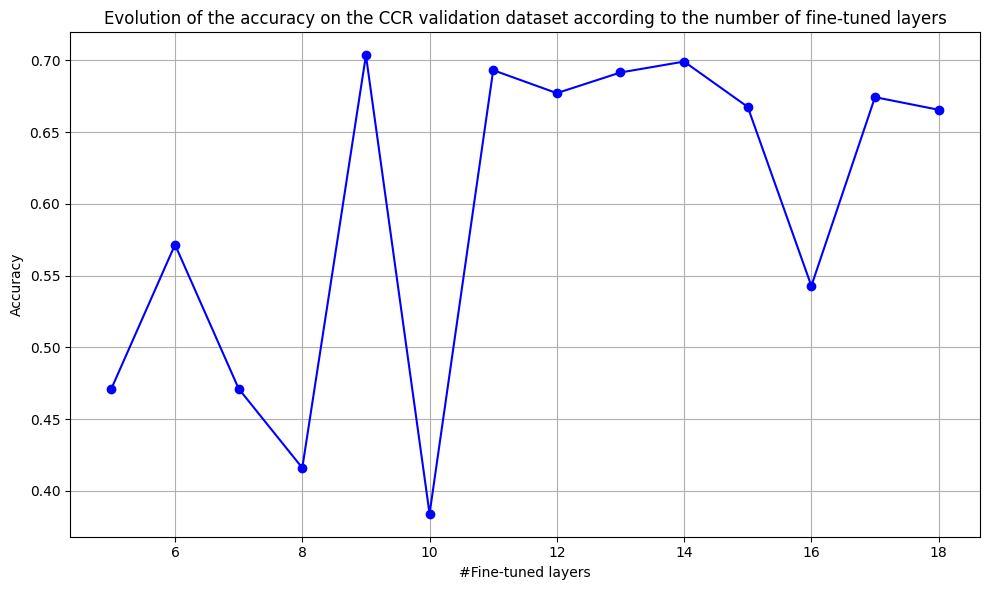

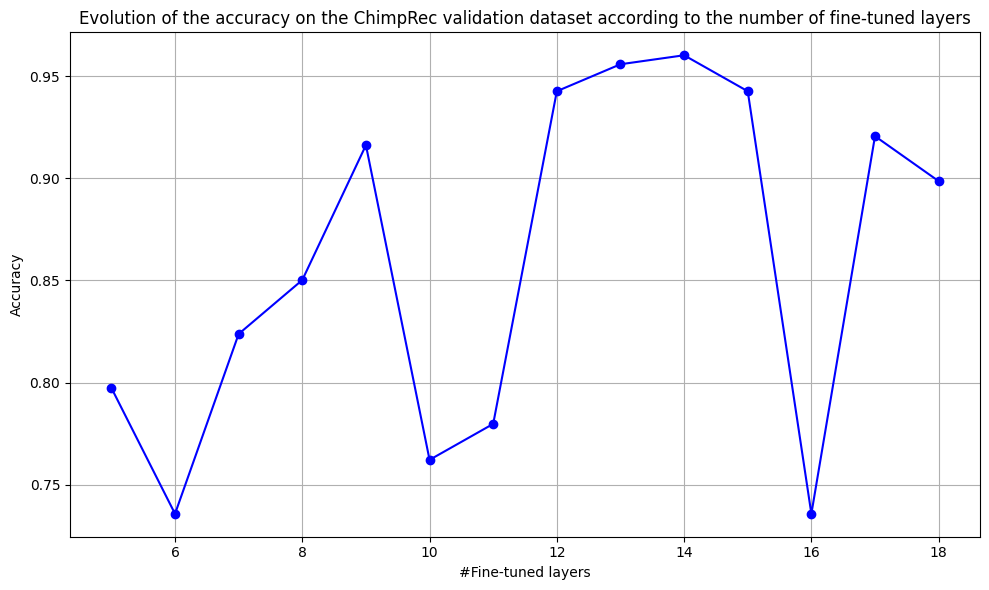

In [4]:
layers = list(precisions_ccr.keys())
ccr_values = [precisions_ccr[k] for k in layers]

plt.figure(figsize=(10, 6))
plt.plot(layers, ccr_values, marker='o', color='blue', linestyle='-')
plt.xlabel('#Fine-tuned layers')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy on the CCR validation dataset according to the number of fine-tuned layers')
plt.grid(True)
plt.tight_layout()
plt.savefig("nb_layer_tuning_CCR_fc.svg")


chimprec_values = [precisions_chimprec[k] for k in layers]

plt.figure(figsize=(10, 6))
plt.plot(layers, chimprec_values, marker='o', color='blue', linestyle='-')
plt.xlabel('#Fine-tuned layers')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy on the ChimpRec validation dataset according to the number of fine-tuned layers')
plt.grid(True)
plt.tight_layout()
plt.savefig("nb_layer_tuning_ChimpRec_fc.svg")

Performance of the best model for ChimpRec on the test set: 

In [ ]:
test_dataset = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Test_set"
dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

num_classes = len(os.listdir(f"{dataset_path}/train"))

model_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_fc/facenet_14_layers_fc.pth"
facenet = CustomFaceNet(num_classes=num_classes)
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()

train_dataset = TripletDataset(os.path.join(dataset_path, "train"), transform=transform)
class_names = list(train_dataset.class_to_idx.keys())

In [55]:
correctly_classified = 0
imgs = os.listdir(test_dataset)
for img in imgs: 
    img_path = f"{test_dataset}/{img}"
    image = Image.open(img_path).convert("RGB")

    predicted_label, _ = predict_image_with_fc(image, facenet, transform, device)
    predicted_identity = class_names[predicted_label]

    real_identity = img[:2]
    if predicted_identity == real_identity: 
        correctly_classified += 1
print(len(imgs))
print(f"Precision on the ChimpRec dataset: {correctly_classified/len(imgs)}")

132
Precision on the ChimpRec dataset: 0.13636363636363635


Performance of the best model for CCR on the test set: 

In [8]:
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"
test_dataset = f"{dataset_path}/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

num_classes = len(os.listdir(f"{dataset_path}/train"))

model_path = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_fc/facenet_14_layers_fc.pth"
facenet = CustomFaceNet(num_classes=num_classes)
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()

train_dataset = TripletDataset(os.path.join(dataset_path, "train"), transform=transform)
class_names = list(train_dataset.class_to_idx.keys())

In [9]:
correctly_classified = 0
imgs = os.listdir(test_dataset)
for img in imgs: 
    img_path = f"{test_dataset}/{img}"
    image = Image.open(img_path).convert("RGB")

    predicted_label, _ = predict_image_with_fc(image, facenet, transform, device)
    predicted_identity = class_names[predicted_label]

    real_identity = img.split("_")[0]
    if predicted_identity == real_identity: 
        correctly_classified += 1
print(len(imgs))
print(f"Precision on the CCR dataset: {correctly_classified/len(imgs)}")

2500
Precision on the CCR dataset: 0.7284
